In [19]:
import sys
import time

import numpy as np
from numpy import kron as kron

import scipy.sparse as sp
from scipy.linalg import expm as expm
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import odeint

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML

sys.path.append('./../lib')
from intertrain import Intertrain

In [20]:
# SDE parameters
# f = A x
# df / dx = A

A = np.array([
    [1.0, 0.0],
    [1.0, 1.0],
])

def f_func(t, x):
    return A@x

def f_der_func(t, x):
    return A

def r0_func(t, x):
    return np.exp(-0.5 * np.diag(x.T@x))

In [21]:
# Time grid

t_min = 0.
t_max = 1.
t_poi = 2 # including t_min and t_max (>= 2)

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

In [22]:
# Spatial grid

x_min = -3.
x_max = +3.
x_poi = 8 # including x_min and x_max (>= 2)

n = x_poi
l = (x_max - x_min) / x_poi

x1d = np.linspace(x_min, x_max, x_poi)
X1, X2 = np.meshgrid(x1d, x1d)
X = np.array([X1, X2]).reshape((2, -1))

In [23]:
# Interpolation class

IT = Intertrain(
    n=[x_poi, x_poi],
    l=[
        [x_min, x_max],
        [x_min, x_max]
    ],
    eps=1.E-6
)

In [24]:
# Initial conditions

x0 = X.copy()
r0 = r0_func(0., x0).reshape(-1, 1)

In [25]:
# Special matrices

I = np.eye(n)
L = IT.dif2()
Z = expm(L)
Z = np.exp(h) * kron(Z, Z)

In [44]:
def step_v(t0, x0, v0, x, f, g):
    v = Z@v0
    return v

def step_w(t0, x0, w0, x, f, g):
    
    q = np.hstack([-1.*np.trace(g).reshape(-1), f.reshape(-1)])
    x = np.hstack([w0.reshape(-1), x0.reshape(-1)])
    
    w = odeint(lambda y, t: q, w0.reshape(-1), [0, -h])
    
    
    
    # w = (1. - h * np.trace(g)) * w0
    return w

def step(t0, x0, v0, w0):
    f = f_func(t0, x0)
    g = f_der_func(t0, x0)
    x = x0 + h * f
    v = step_v(t0, x0, v0, x, f, g)
    w = step_w(t0, x0, v, x, f, g)

    return (x, v, w)

In [45]:
def calc():
    x = x0.copy()
    r = r0.copy()
    v = r.copy()
    w = r.copy()

    X_list = [x]
    R_list = [r]
    
    for t in T[:-1]:
        x, v, w = step(t, x, v, w)
        X_list.append(x)
        R_list.append(w)
    
    return (X_list, R_list)

In [46]:
# Run caclulations

X_list, R_list = calc()

RuntimeError: The size of the array returned by func (129) does not match the size of y0 (64).

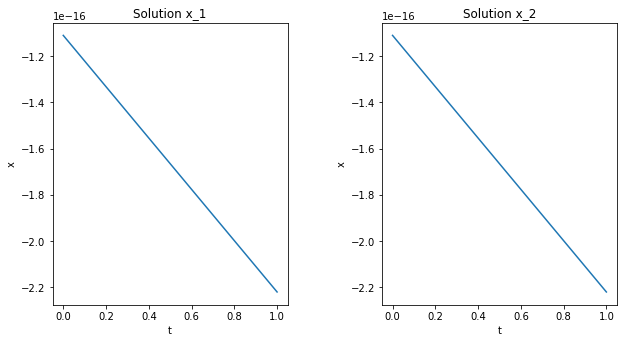

In [15]:
# Plot solution x for each dimension on separate plot vs time

fig = plt.figure(figsize=(8, 4))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1], height_ratios=[1]
)

ax = fig.add_subplot(gs[0, 0])
ax.plot(T, [np.mean(X[0, :]) for X in X_list], label='x_1')
ax.set_title('Solution x_1')
ax.set_xlabel('t')
ax.set_ylabel('x')

ax = fig.add_subplot(gs[0, 1])
ax.plot(T, [np.mean(X[1, :]) for X in X_list], label='x_2')
ax.set_title('Solution x_2')
ax.set_xlabel('t')
ax.set_ylabel('x')

plt.show()

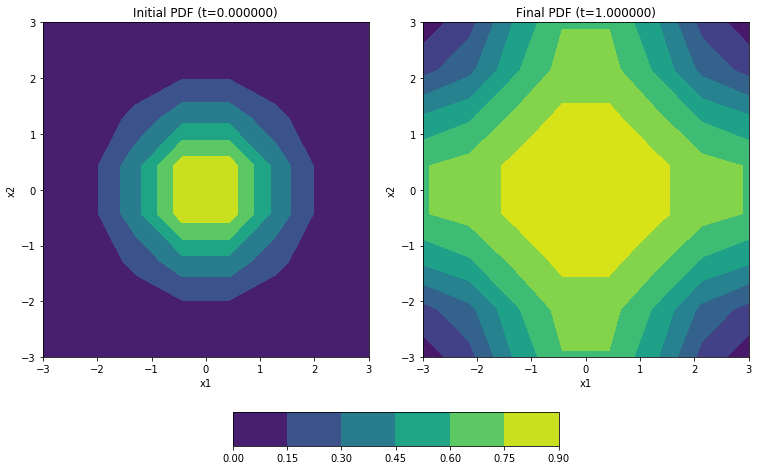

In [16]:
# Plot distribution (initial and final) on spatial grid

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=4, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1, 1, 1], height_ratios=[10, 1]
)

ax = fig.add_subplot(gs[0, :2])
ct1 = ax.contourf(X1, X2, R_list[0].reshape((x_poi, x_poi)))
ax.set_title('Initial PDF (t=%f)'%t_min)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[0, 2:])
ct2 = ax.contourf(X1, X2, R_list[-1].reshape((x_poi, x_poi)))
ax.set_title('Final PDF (t=%f)'%t_max)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[1, 1:3])
cb = plt.colorbar(ct1, cax=ax, orientation='horizontal')
# cb.add_lines(ct2)

plt.show()

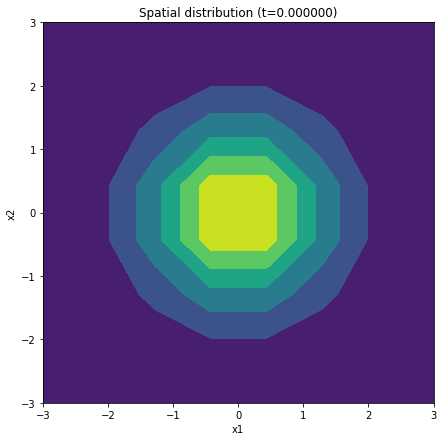

In [17]:
# Build animation for distribution vs time

# Interval between frames
delt = 50 

# Path to ffmpeg executable
plt.rcParams['animation.ffmpeg_path'] = './../tmp/ffmpeg'

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

def run(i):
    t = T[i]
    r = R_list[i].reshape((x_poi, x_poi))

    ax.clear()
    ax.set_title('Spatial distribution (t=%f)'%t)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ct = ax.contourf(X1, X2, r)
    return (ct,)

anim = animation.FuncAnimation(fig, run, frames=len(T), interval=delt, blit=False)
HTML(anim.to_html5_video())

In [9]:
def calc(x, k):
    print('calc ', k, x.shape)
    
    if k == 0:
        return r0_func(x)
    
    f = f_func(x)
    g = f_der_func(x)
    
    func = lambda x: calc(x, k-1)

    r = IT.copy().init(func).prep().calc(x - h * f)
    
    if k == t_poi:
        return r
    
    print('x ', r.shape)

    
    #v = Z@r
    #w = (1. - h * np.trace(g)) * v
    #r = w
    
    return r

r = calc(x0, t_poi)

calc  2 (2, 64)
calc  1 (2, 8)
calc  0 (2, 8)
calc  0 (2, 16)
calc  0 (2, 16)
calc  0 (2, 24)
swp: 0/199 er_rel = 4.6e+00 er_abs = 6.2e+00 erank = 3.0 fun_eval: 64
calc  0 (2, 24)
calc  0 (2, 32)
calc  0 (2, 32)
calc  0 (2, 40)
swp: 1/199 er_rel = 5.2e-16 er_abs = 6.9e-16 erank = 5.0 fun_eval: 192
x  (8,)
calc  1 (2, 16)
calc  0 (2, 8)
calc  0 (2, 16)
calc  0 (2, 16)
calc  0 (2, 24)
swp: 0/199 er_rel = 3.8e+00 er_abs = 5.2e+00 erank = 3.0 fun_eval: 64
calc  0 (2, 24)
calc  0 (2, 32)
calc  0 (2, 32)
calc  0 (2, 40)
swp: 1/199 er_rel = 5.1e-16 er_abs = 6.8e-16 erank = 5.0 fun_eval: 192
x  (16,)
calc  1 (2, 16)
calc  0 (2, 8)
calc  0 (2, 16)
calc  0 (2, 16)
calc  0 (2, 24)
swp: 0/199 er_rel = 4.0e+00 er_abs = 5.4e+00 erank = 3.0 fun_eval: 64
calc  0 (2, 24)
calc  0 (2, 32)
calc  0 (2, 32)
calc  0 (2, 40)
swp: 1/199 er_rel = 5.2e-16 er_abs = 6.9e-16 erank = 5.0 fun_eval: 192
x  (16,)
calc  1 (2, 24)
calc  0 (2, 8)
calc  0 (2, 16)
calc  0 (2, 16)
calc  0 (2, 24)
swp: 0/199 er_rel = 4.4e+00 

In [ ]:
# Plot distribution (initial and final) on spatial grid

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=4, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1, 1, 1], height_ratios=[10, 1]
)

ax = fig.add_subplot(gs[0, :2])
ct1 = ax.contourf(X1, X2, r0.reshape((x_poi, x_poi)))
ax.set_title('Initial PDF (t=%f)'%t_min)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[0, 2:])
ct2 = ax.contourf(X1, X2, r.reshape((x_poi, x_poi)))
ax.set_title('Final PDF (t=%f)'%t_max)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[1, 1:3])
cb = plt.colorbar(ct1, cax=ax, orientation='horizontal')
# cb.add_lines(ct2)

plt.show()

In [ ]:
import tt

def interpolate(r0, x0, x):
    y = tt.tensor(r0.reshape((n, n)), IT.eps)
    IT.init(Y=y)
    IT.prep()
    return IT.calc(x)

In [ ]:
def step(x0, r0):
    f = A@x0       # f(x, t)
    g = A          # d f(x, t) / dx
    x = x0 + h * f
    r = (1. - h * np.trace(g)) * Z@interpolate(r0, x0, x)

    return (x, r)

In [ ]:
def calc():
    x = x0.copy()
    r = r0.copy()

    X_list = [x]
    R_list = [r]
    
    for i in range(t_poi-1):
        x, r = step(x, r)
        X_list.append(x)
        R_list.append(r)
        print('\rIter #%d | '%(i+1), end='')
    
    return (X_list, R_list)

In [ ]:
# Run caclulations

X_list, R_list = calc()

In [ ]:
# Plot solution x for each dimension on separate plot vs time

fig = plt.figure(figsize=(8, 4))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1], height_ratios=[1]
)

ax = fig.add_subplot(gs[0, 0])
ax.plot(T, [np.mean(X[0, :]) for X in X_list], label='x_1')
ax.set_title('Solution x_1')
ax.set_xlabel('t')
ax.set_ylabel('x')

ax = fig.add_subplot(gs[0, 1])
ax.plot(T, [np.mean(X[1, :]) for X in X_list], label='x_2')
ax.set_title('Solution x_2')
ax.set_xlabel('t')
ax.set_ylabel('x')

plt.show()

In [ ]:
# Plot distribution (initial and final) on spatial grid

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=4, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1, 1, 1, 1], height_ratios=[10, 1]
)

ax = fig.add_subplot(gs[0, :2])
ct1 = ax.contourf(X1, X2, r0.reshape((x_poi, x_poi)))
ax.set_title('Initial PDF (t=%f)'%t_min)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[0, 2:])
ct2 = ax.contourf(X1, X2, r.reshape((x_poi, x_poi)))
ax.set_title('Final PDF (t=%f)'%t_max)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(gs[1, 1:3])
cb = plt.colorbar(ct1, cax=ax, orientation='horizontal')
# cb.add_lines(ct2)

plt.show()

In [ ]:
# Build animation for distribution vs time

# Interval between frames
delt = 50 

# Path to ffmpeg executable
plt.rcParams['animation.ffmpeg_path'] = './../tmp/ffmpeg'

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

def run(i):
    t = T[i]
    r = R_list[i].reshape((x_poi, x_poi))

    ax.clear()
    ax.set_title('Spatial distribution (t=%f)'%t)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ct = ax.contourf(X1, X2, r)
    return (ct,)

anim = animation.FuncAnimation(fig, run, frames=len(T), interval=delt, blit=False)
HTML(anim.to_html5_video())